In [6]:

import os
import glob
import random

import nibabel
import matplotlib.pyplot as plot
import math
import numpy

from math import floor

%matplotlib inline


In [7]:

class Volume( object ):
    @property
    def axial_data( self ):
        pass


    def axial_image( self, z, relative_to_centre = False ):
        centre = math.floor( self.axial_data.shape[ 2 ] / 2 )
        i = centre + z if relative_to_centre else z
        return self.axial_data[ :, :, i ]



class BasicVolume( Volume ):

    def __init__( self, axial_data ):
        self.__axial_data = axial_data
        

    @property
    def axial_data( self ):
        return self.__axial_data



class AnalyseFormatVolume( Volume ):


    def __init__( self, case_id, file_path ):
        self.__case_id = case_id
        self.__file_path = file_path
        self.__meta_data = []
        self.__axial_data = []


    @property
    def meta_data( self ):
        if self.__meta_data == []:
            self.__meta_data = nibabel.analyze.load( self.__file_path )
        return self.__meta_data


    @property
    def axial_data( self ):
        if self.__axial_data == []:
            raw_data = self.meta_data.get_data()
            transposed_data = numpy.transpose( raw_data, ( 1, 0, 2, 3 ) )
            x, y, z, _ = transposed_data.shape
            self.__axial_data = transposed_data.reshape( ( x, y, z ) )
        return self.__axial_data


    


In [9]:
class OasisDataCase( object ):


    def __init__( self, dataset_path, case_id ):

        self.__case_id = case_id
        self.__case_path = dataset_path + "/" + case_id
        pattern = "_mpr_n?_anon_111_t88_masked_gfc"

        input_path = self.__case_path + "/PROCESSED/MPRAGE/T88_111"
        input_file_pattern = case_id + pattern + ".img"
        input_files = glob.glob( input_path + "/" + input_file_pattern )
        assert( len( input_files ) == 1 )
        self.__input = AnalyseFormatVolume( case_id, input_files[ 0 ] )

        label_path = self.__case_path + "/FSL_SEG/" 
        label_file_pattern = case_id + pattern + "_fseg.img"
        label_files = glob.glob( label_path + "/" + label_file_pattern )
        assert( len( label_files ) == 1 )
        self.__label = AnalyseFormatVolume( case_id, label_files[ 0 ] )

        self.__mask = BasicVolume( self.__input.axial_data > 0 )
        self.__shape = self.__mask.axial_data.shape
        assert( self.__input.axial_data.shape == self.__shape )
        assert( self.__label.axial_data.shape == self.__shape )


    @property
    def input( self ):
        return self.__input


    @property
    def label( self ):
        return self.__label
        

    @property
    def mask( self ):
        return self.__mask
        

    @property
    def shape( self ):
        return self.__shape
        


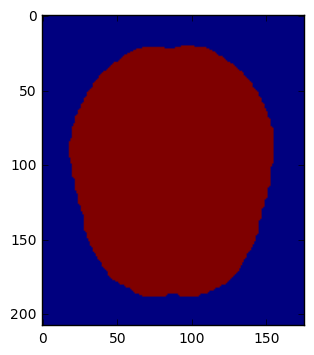

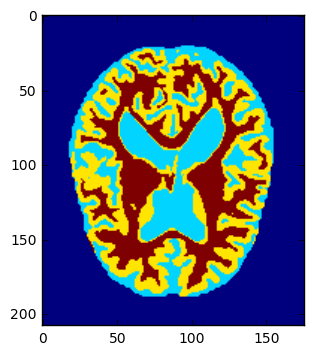

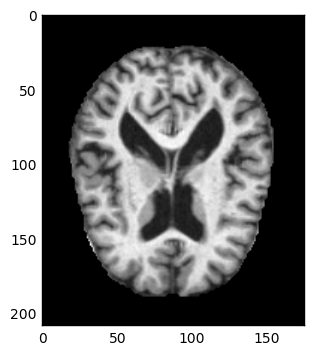

/home/daniel/.local/lib/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:46: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [10]:

dataset_path = "../../data/oasis-cross"

case1 = OasisDataCase( dataset_path, "OAS1_0001_MR1" )
case1_input = case1.input.axial_image( 0, relative_to_centre = True )
case1_label = case1.label.axial_image( 0, relative_to_centre = True )
case1_mask = case1.mask.axial_image( 0, relative_to_centre = True ).astype( numpy.int )

plot.imshow( case1_input, cmap="gray" )
plot.show()
plot.imshow( case1_label )
plot.show()
plot.imshow( case1_mask )
plot.show()


In [12]:

def Voxel( v ) :
    return numpy.array( v ).astype( numpy.int )


class Sample( object ):

      
    @staticmethod
    def point_within_cuboid( minimum_vertex, maximum_vertex ):

        x = random.randint( minimum_vertex[ 0 ], maximum_vertex[ 0 ] )
        y = random.randint( minimum_vertex[ 1 ], maximum_vertex[ 1 ] )
        z = random.randint( minimum_vertex[ 2 ], maximum_vertex[ 2 ] )
        return (x, y, z)

      
    @staticmethod
    def window_within_mask( window_shape, case ):

        mask = case.mask.axial_data
        span = Voxel( window_shape ) - Voxel(( 1, 1, 1 )) 
        half_span = Voxel( span / 2 )

        maximum_voxel = Voxel( mask.shape ) - Voxel(( 1, 1, 1 ))
        maximum_extent = maximum_voxel - half_span
        minimum_extent = half_span

        while True:
            ( x, y, z ) = Sample.point_within_cuboid( minimum_extent, maximum_extent )
            if mask[ x, y, z ] :
                centre = Voxel(( x, y, z ))
                minimum_vertex = centre - half_span
                maximum_vertex = minimum_vertex + span
                return ( minimum_vertex, maximum_vertex )


    @staticmethod
    def window_within_masks( window_shape, cases ):

        N = len( cases )
        n = random.randint( 0, N )
        minimum_vertex, maximum_vertex = Sample.window_within_mask( window_shape, cases[ n ] )

        return ( n, minimum_vertex, maximum_vertex );


    @staticmethod
    def centre_of_window( window_shape ):

        return Voxel( Voxel( window_shape ) / 2 )


    def __init__( self, cases, window_shape ):

        ( case, minimum_vertex, maximum_vertex ) = Sample.window_within_masks( window_shape, cases )
        x0, y0, z0 = minimum_vertex
        xN, yN, zN = maximum_vertex + Voxel(( 1, 1, 1 ))

        X, Y, Z = cases[ case ].shape
        assert( x0 >= 0 and xN <= X )
        assert( y0 >= 0 and yN <= Y )
        assert( z0 >= 0 and zN <= Z )

        x, y, z = Sample.centre_of_window( window_shape )
        self.__centre = ( x, y, z )
        self.__input = cases[ case ].input.axial_data[ x0:xN, y0:yN, z0:zN ]
        self.__label = cases[ case ].label.axial_data[ x, y, z ]


    @property
    def input( self ):
        return self.__input


    @property
    def label( self ):
        return self.__label


    @property
    def centre( self ):
        return self.__centre



In [13]:

class OasisDataSet( object ):


    def __init__( self, root_path, max_cases ):

        self.__root = root_path
        self.__case_ids = os.listdir( root_path )

        cases_found = len( self.__case_ids )
        assert( cases_found > 0 )

        cases_to_read = min( cases_found, max_cases )        
        self.__cases = [ OasisDataCase( root_path, id ) for id in self.__case_ids ]


    @property
    def cases( self ):
        return self.__cases


    def sample( self, count, window_shape, random_state ):
        random.setstate( random_state )
        return [ Sample( self.cases, window_shape ) for i in range( 0, count ) ] 

    


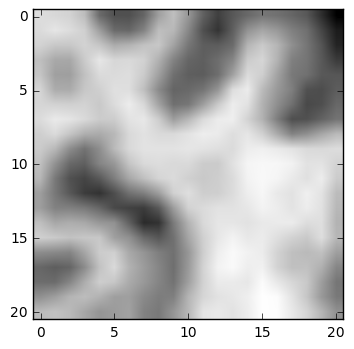

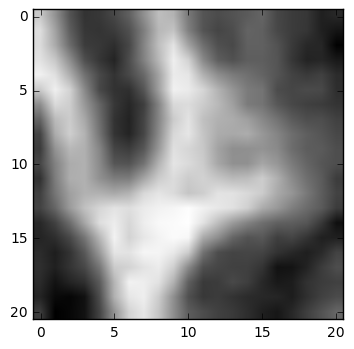

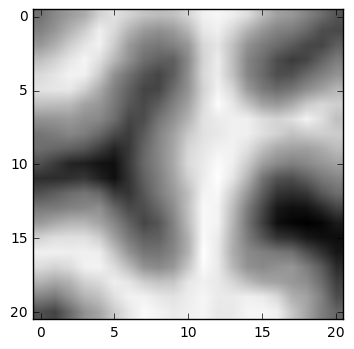

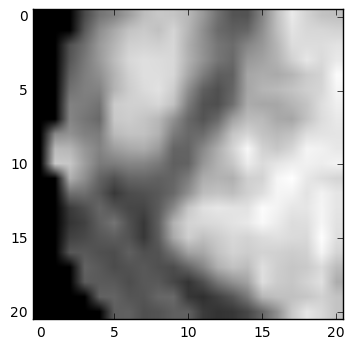

/home/daniel/.local/lib/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:46: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [14]:

dataset_count = 10
sample_count = 4

width = 21
height = 21

random.seed( 42 )
state = random.getstate()
dataset = OasisDataSet( dataset_path, dataset_count )
samples = dataset.sample( sample_count, ( width, height, 1 ), state )

for sample in samples:

    plot.imshow( sample.input.reshape( ( width, height ) ), cmap="gray" )
    plot.show()
    
